In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans

# 1. EDA

## 1) data Pre-processing

In [2]:
df = pd.read_excel("../dataset.xlsx",sheet_name="드로니아가 보유한 데이터 셋",header=1)
df = df.drop(columns=['Unnamed: 0','address','geometry','extra','startDate','endDate','createdAt'])
df = df.dropna(axis=0)

### 지형 정보(x,y,area)와 작업 정보(Task, Team)만 추출

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111737 entries, 0 to 113039
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       111737 non-null  float64
 1   y       111737 non-null  float64
 2   area    111737 non-null  float64
 3   TaskId  111737 non-null  int64  
 4   TeamId  111737 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 5.1 MB


## 2) Data Visualization

### 1. Area Visualization with Task ID

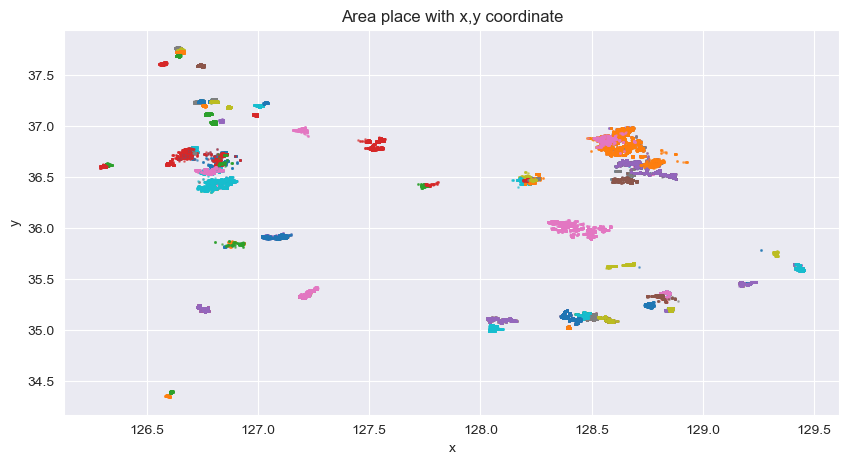

In [4]:
plt.figure(1, figsize=(10, 5))
for task_id in df['TaskId'].unique():
    plt.scatter(x = 'x' , y = 'y' , data = df[df['TaskId']==task_id],
                s = 1 , alpha = 0.5)
    plt.xlabel('x'), plt.ylabel('y')
plt.title('Area place with x,y coordinate')
plt.show()

### 2. Area Visualization with Team ID

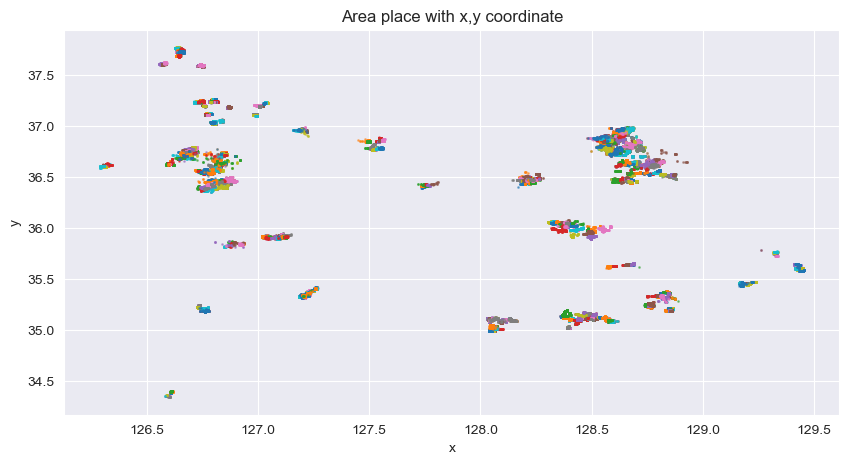

In [5]:
plt.figure(1, figsize=(10, 5))
for team_id in df['TeamId'].unique():
    plt.scatter(x = 'x' , y = 'y' , data = df[df['TeamId']==team_id],
                s = 1 , alpha = 0.5)
    plt.xlabel('x'), plt.ylabel('y')
plt.title('Area place with x,y coordinate')
plt.show()

### 3. 팀 1개가 작업한 범위, 작업 1개 당 팀의 갯수 구하기

In [6]:
# 팀 1개가 작업한 영역 범위 구하기 -> 10~20
area_per_team = df.groupby('TeamId')['area'].agg('sum')
q_low = area_per_team.quantile(0.05)
q_hi  = area_per_team.quantile(0.95)
area_filtered = area_per_team[(area_per_team < q_hi) & (area_per_team > q_low)]
print(area_filtered.describe())

count       834.000000
mean     218414.232974
std      128089.484130
min       29327.700000
25%      122067.750000
50%      190511.350000
75%      298528.025000
max      592657.500000
Name: area, dtype: float64


In [12]:
# 작업 1개 당 참여한 팀의 갯수; 평균 6개 팀
team_cnt_per_task = df.groupby('TaskId').agg({"TeamId":'nunique'})['TeamId']
print(team_cnt_per_task.describe())

count    142.000000
mean       6.535211
std        4.131975
min        2.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       21.000000
Name: TeamId, dtype: float64


# Clustering use K-means

1. 테스트 용 군집화

(160, 2)


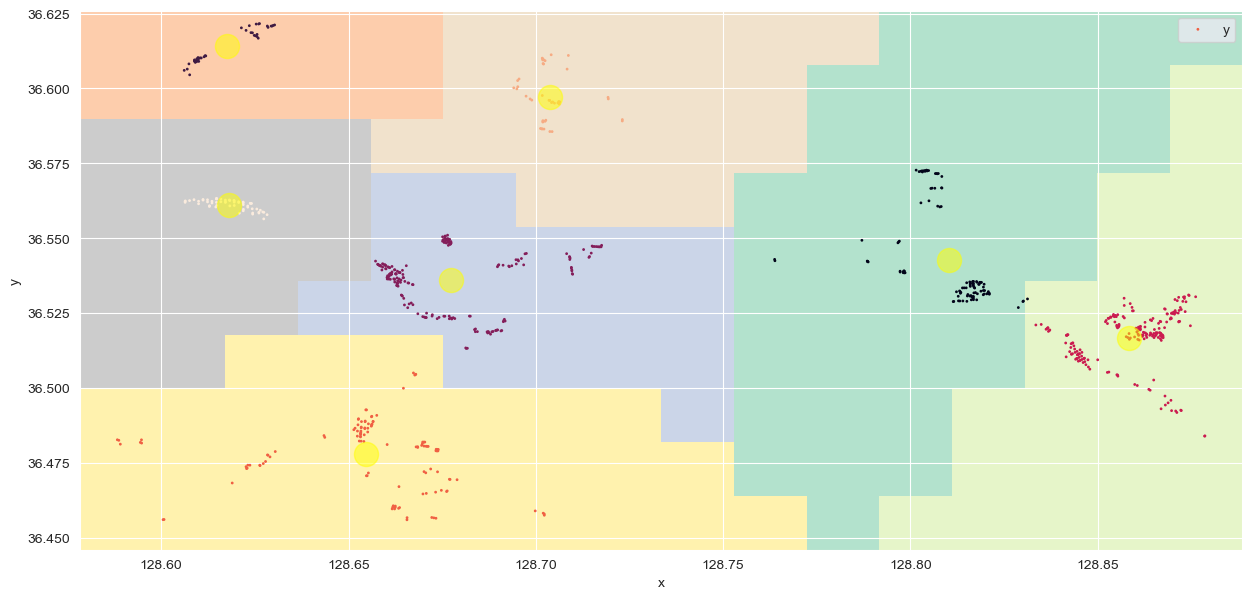

In [26]:
from sklearn.cluster import KMeans

task = df[df['TaskId']==618978]

# x,y coordinate about area (779,2)
X1 = task[['x' , 'y']].iloc[: , :].values

# K-means algorithm
algorithm = (KMeans(n_clusters = 7 ,init='k-means++', n_init = 10 ,max_iter=300,
                            tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)

# input data에 의한 clustering 결과 (라벨, 중점)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X1[:, 0].min()-0.01, X1[:, 0].max()+0.01
y_min, y_max = X1[:, 1].min()-0.01, X1[:, 1].max()+0.01

# 좌표 상 x,y 축 격자 생성
xx, yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))

# 격자점에 대한 kmeans clustering
Z = algorithm.predict(np.c_[xx.ravel(),yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()

# 10*16 size로 결과 재배열
Z = Z.reshape(xx.shape)

# 격자점 클러스터링
plt.imshow(Z , interpolation='nearest',
           extent=(x_min, x_max, yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

# 데이터 클러스터링
plt.scatter( x = 'x' ,y = 'y' , data = task , c = labels1 ,s = 1 )
# 중심점 뿌리기
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'yellow' , alpha = 0.5)

plt.ylabel('y') , plt.xlabel('x')
plt.legend()
plt.show()

2. 모든 Task에 대해 군집화 실행

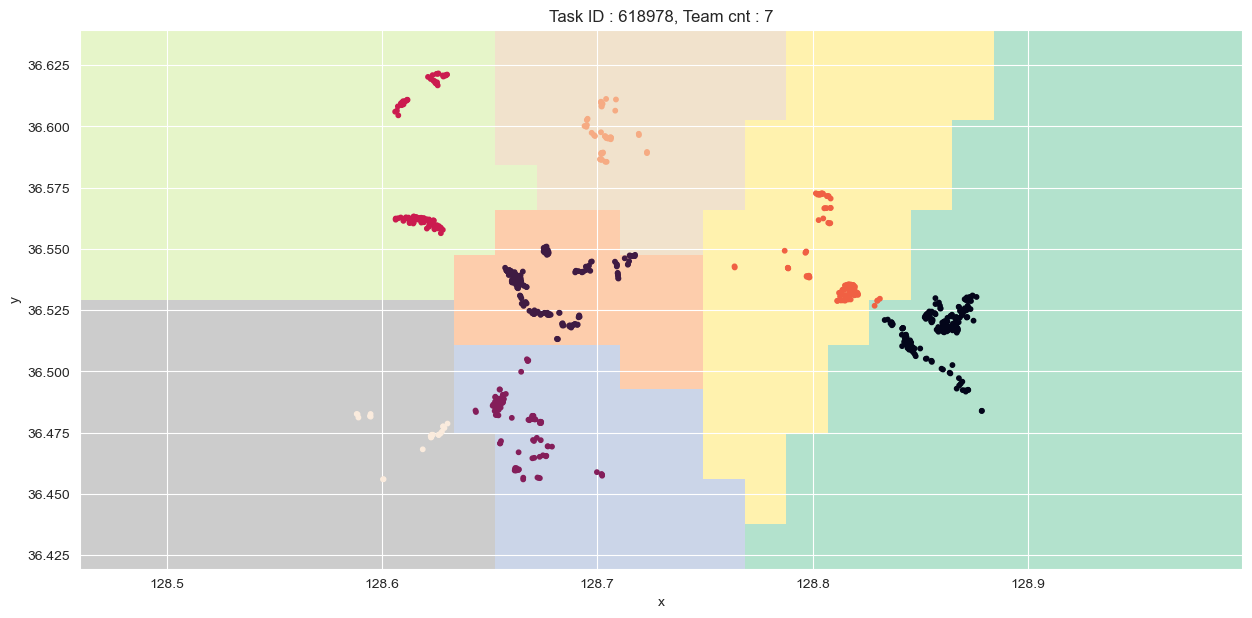

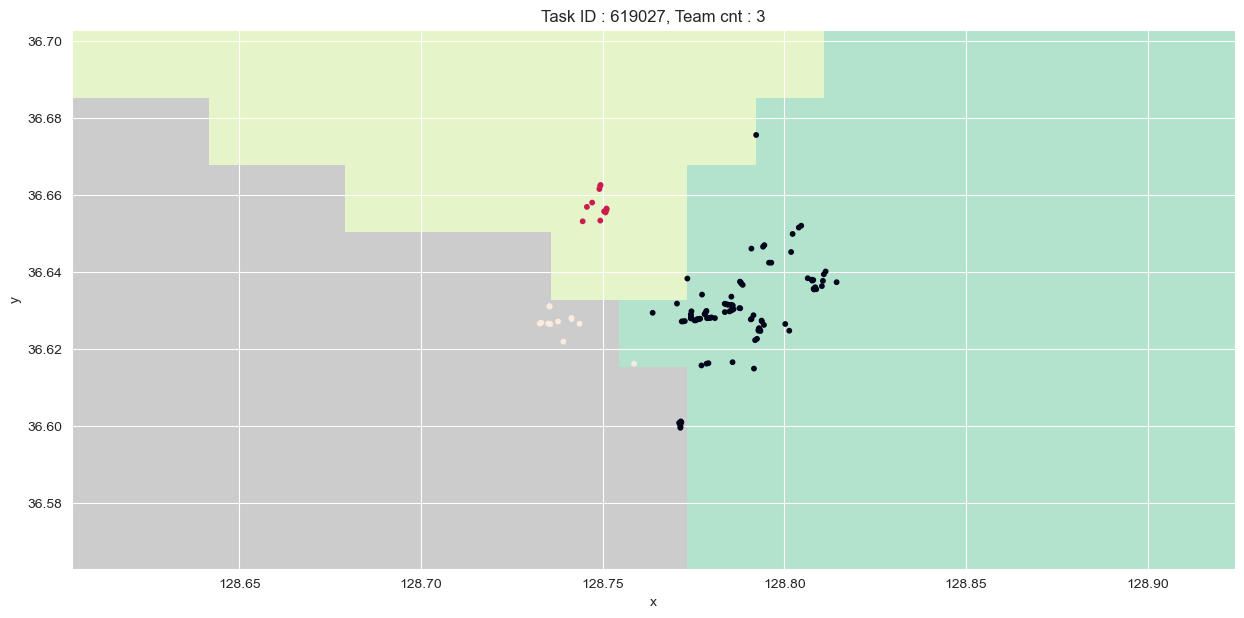

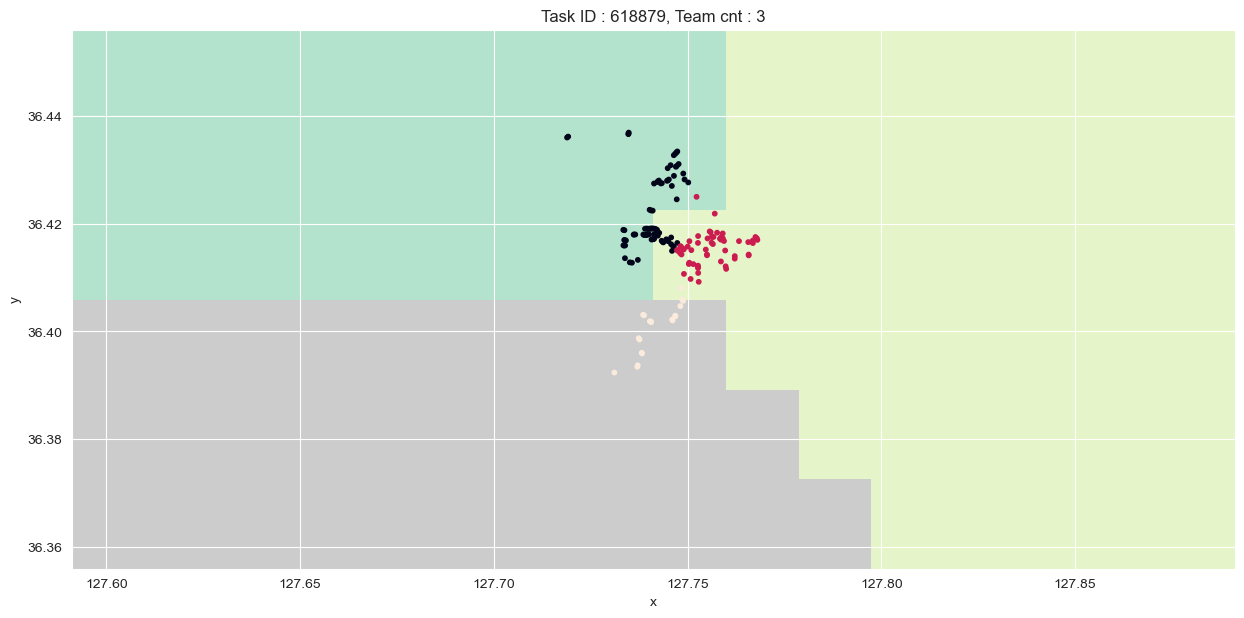

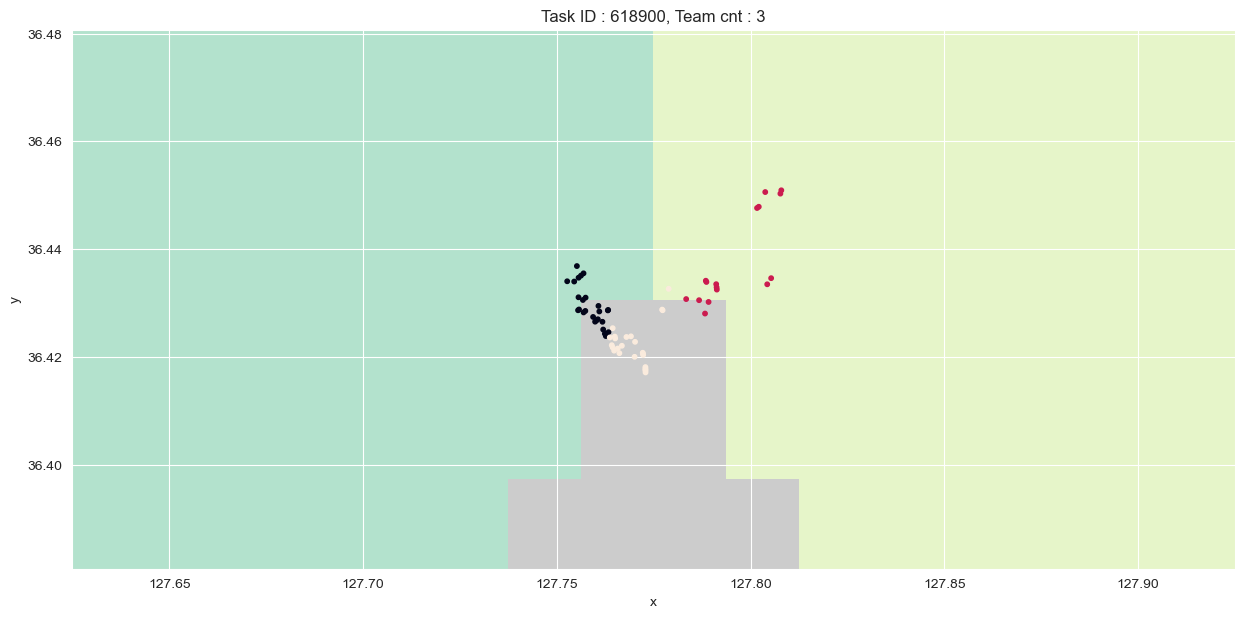

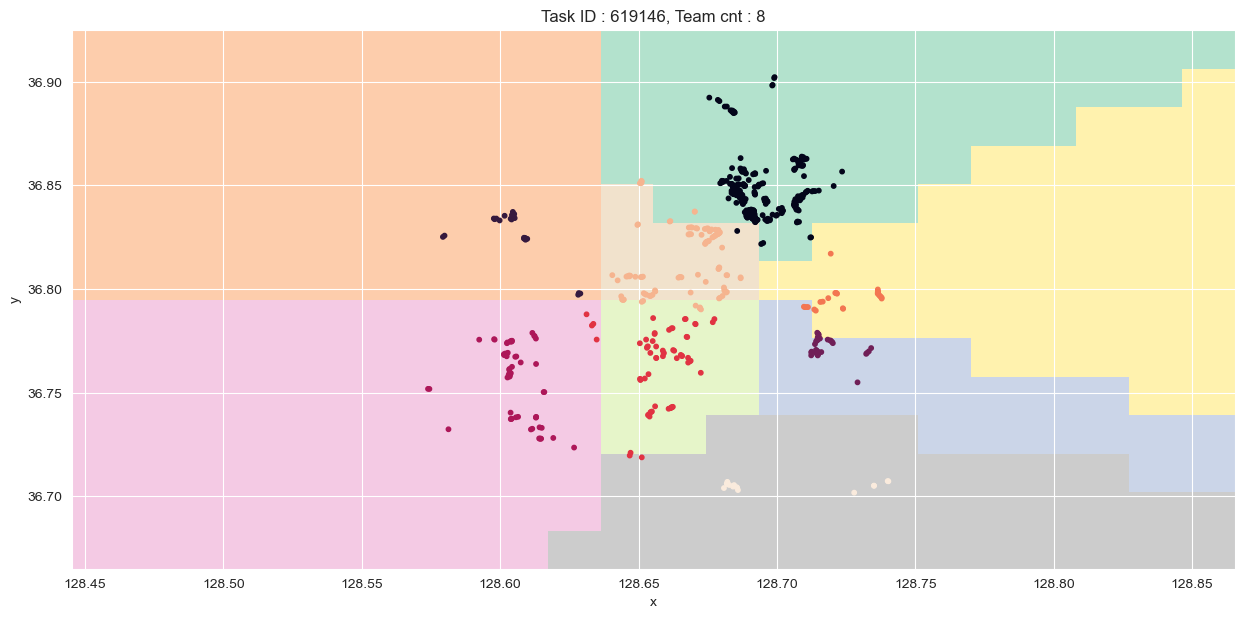

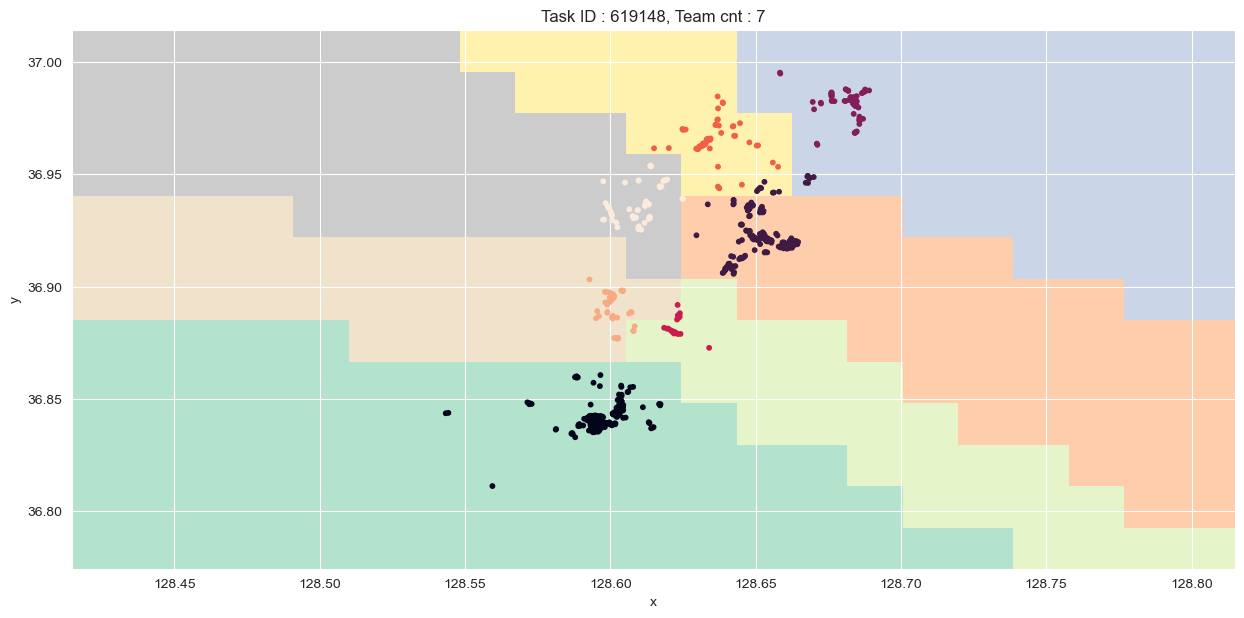

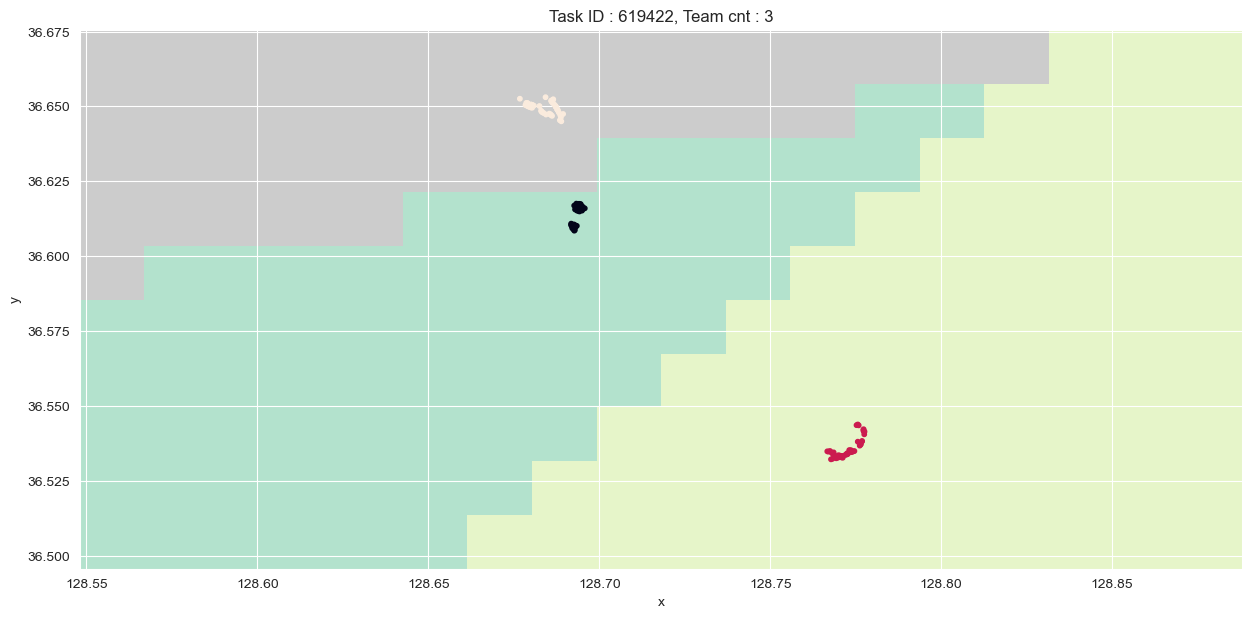

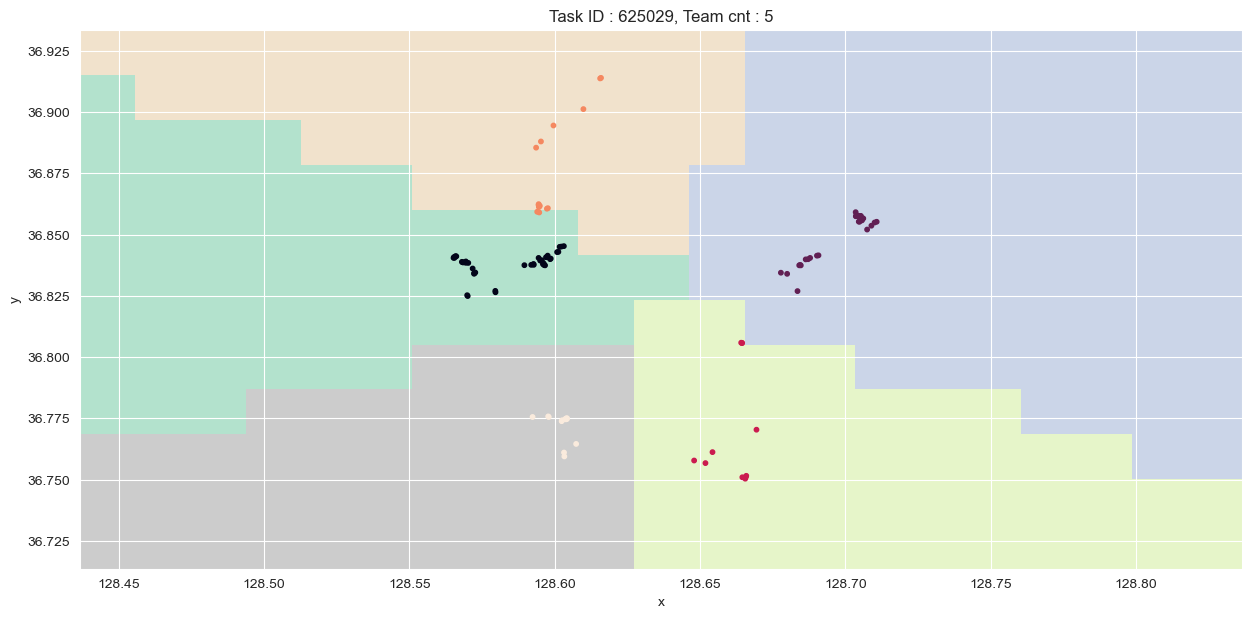

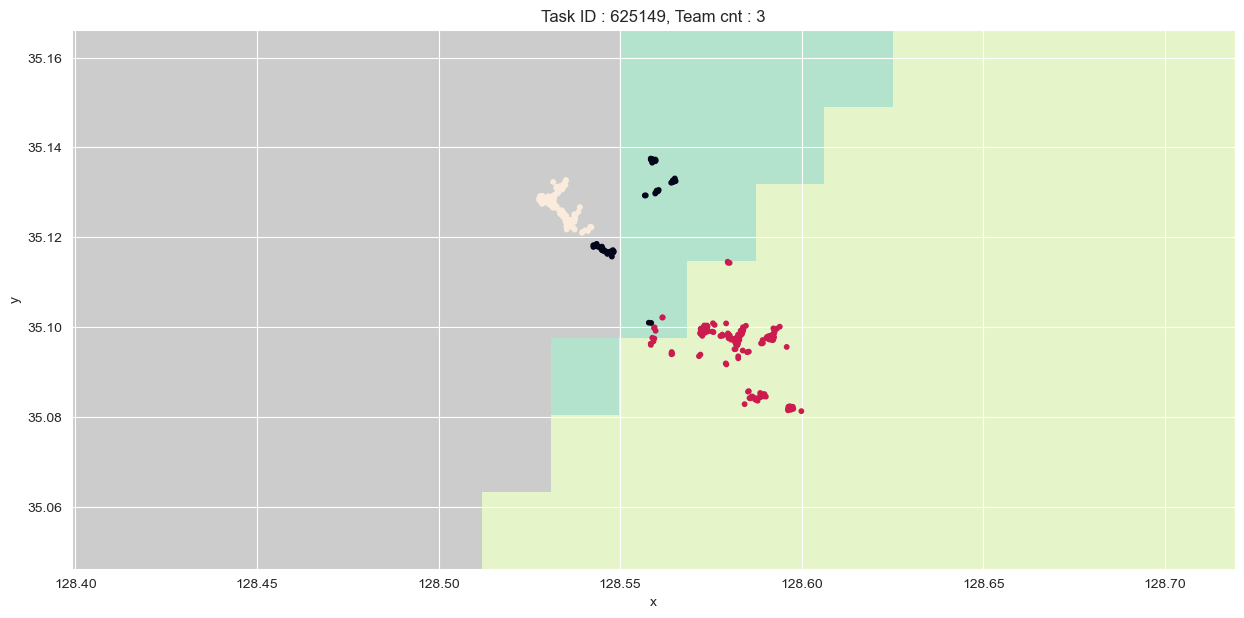

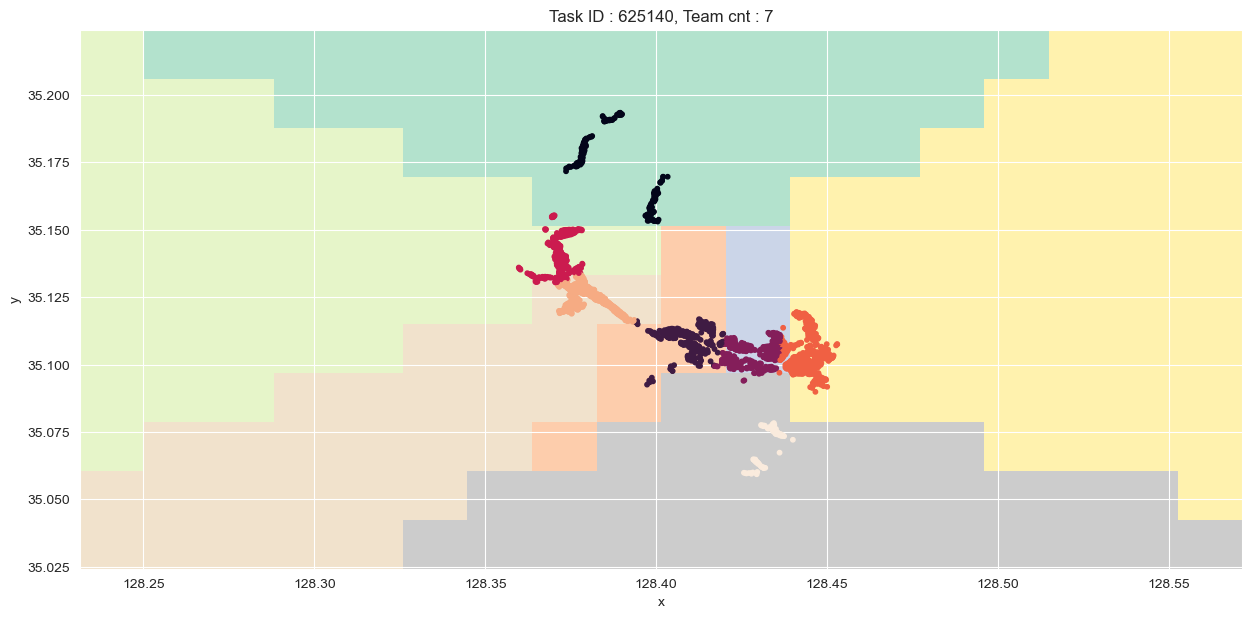

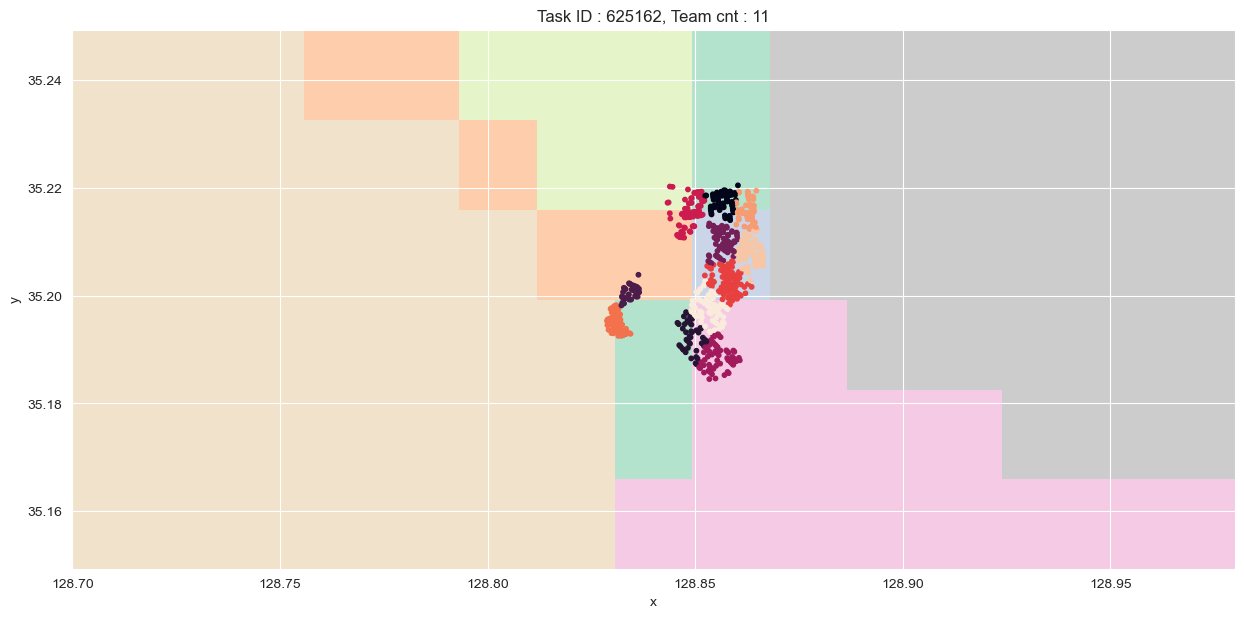

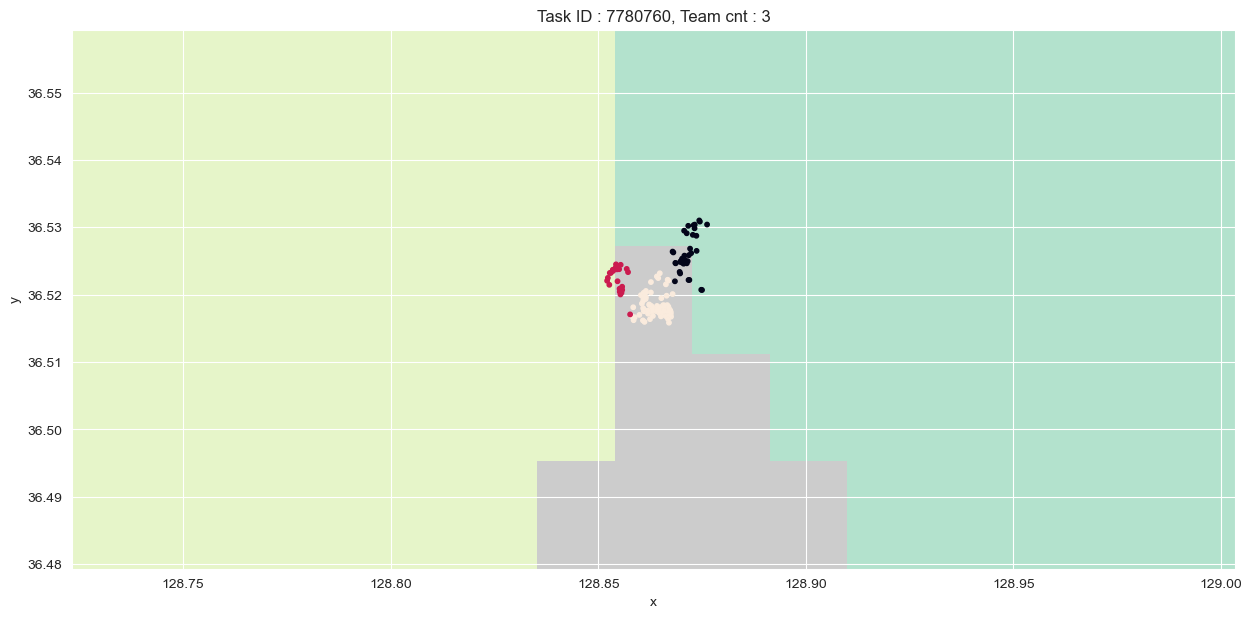

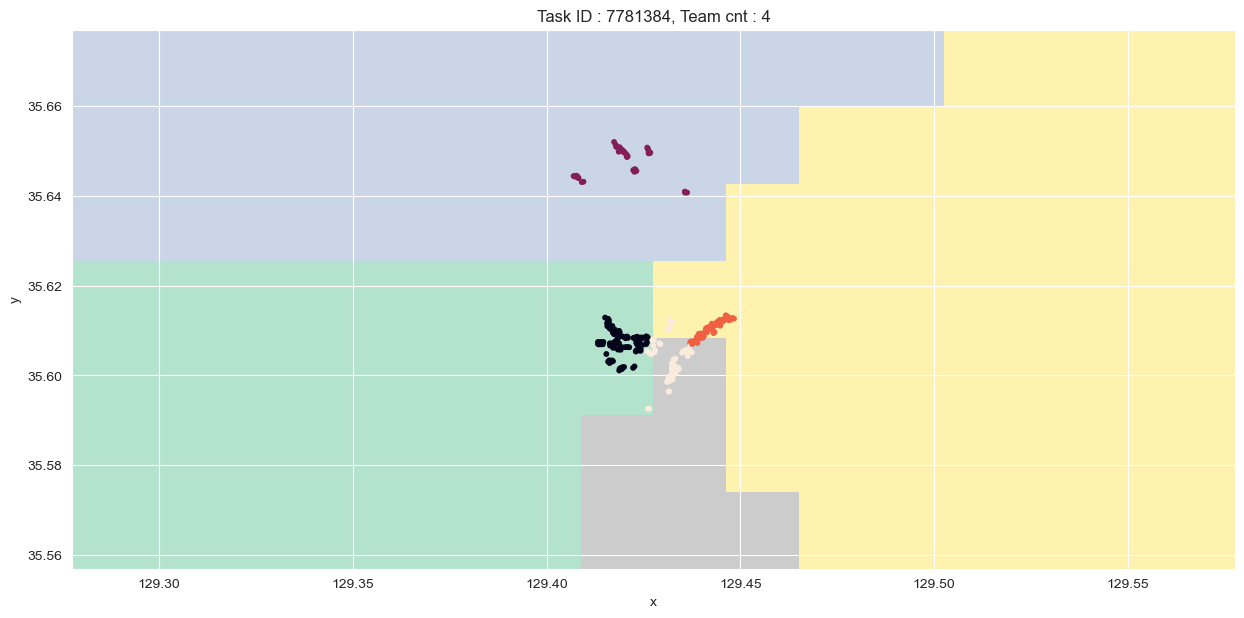

KeyboardInterrupt: 

In [14]:
from sklearn.cluster import KMeans
# 1개 Task Id에 대하여, clustering
'''Coordinate'''
for task_id in df['TaskId'].unique():
    team_cnt = team_cnt_per_task.loc[task_id]

    task = df[df['TaskId']==task_id]
    X1 = task[['x' , 'y']].iloc[: , :].values

    algorithm = (KMeans(n_clusters = team_cnt ,init='k-means++', n_init = 'auto' ,max_iter=300,
                            tol=0.0001,  random_state= 111  , algorithm='elkan') )

    algorithm.fit(X1)

    labels1 = algorithm.labels_

    centroids1 = algorithm.cluster_centers_

    h = 0.02
    x_min, x_max = X1[:, 0].min()*0.999, X1[:, 0].max()*1.001
    y_min, y_max = X1[:, 1].min()*0.999, X1[:, 1].max()*1.001

    xx, yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
    Z = algorithm.predict(np.c_[xx.ravel(),yy.ravel()])

    plt.figure(1 , figsize = (15 , 7) )
    plt.clf()
    Z = Z.reshape(xx.shape)
    # 구분 배경
    plt.imshow(Z , interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

    plt.scatter( x = 'x' ,y = 'y' , data = task , c = labels1 ,s = 10, label=task )
    # centroid 위치 표시
    # plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'yellow' , alpha = 0.5)
    plt.ylabel('y') , plt.xlabel('x')
    plt.title('Task ID : {}, Team cnt : {}'.format(task_id, team_cnt))
    plt.show()

# 평가척도